Ниже код, где я подбирал модель. К сожелению изначально это делал в отдельном файлике (а не предоставленном tune models), поэтому разделы не сохранились. Пересчет в другом занял бы слишком много времени. Прошу прощения за такое, больше не повторится.

Пробовал разный feature engineering, разный подбор параметров, в результате все приводит только к ухудшению модели. Поэтому остановился на достаточно просто columntransformer, где для чисел просто делаем скейлинг, для категорий onehot и скейлинг, а для фич color и carat более сложную замену с учетом ценности (на основе википедии).

Что хотелось попробовать, но не получилось: строить много полиномов (скорее всего это бы не помогло, но мне просто не хватило оперативной памяти), преобразование к нормальному распределению (слишком поздно решился попробовать и поэтому не хватило времени). Большинство работы проводил на срезе датасета, для оптимизации потраченного времени, возможно из-за этого я что-то упустил, зато выполнял код быстрее. Пару раз пользовался randomsearchcv, поскольку при большой сетке гиперпараметров он позволяет быстрее сойтись к решению, чем grid.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import train_test_split, GridSearchCV, \
                                    ShuffleSplit, KFold

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

from sklearn.preprocessing import MinMaxScaler, StandardScaler, \
                                  RobustScaler, PolynomialFeatures, \
                                  OrdinalEncoder, LabelEncoder, \
                                  OneHotEncoder, TargetEncoder, \
                                  QuantileTransformer, PowerTransformer, \
                                  KBinsDiscretizer

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, RANSACRegressor, \
                                 Ridge, Lasso, LinearRegression

from sklearn.metrics import recall_score, precision_score, \
                            f1_score, ConfusionMatrixDisplay, \
                            confusion_matrix, roc_auc_score, \
                            RocCurveDisplay, PrecisionRecallDisplay, \
                            roc_curve, precision_recall_curve, \
                            PrecisionRecallDisplay, make_scorer, \
                            mean_squared_error

from sklearn.compose import ColumnTransformer, make_column_selector,\
                            make_column_transformer, TransformedTargetRegressor
import category_encoders as ce
import pickle

In [2]:
data_raw = pd.read_csv('train.csv')
data_raw.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.55,Ideal,I,SI1,61.7,55.0,1134,5.29,5.31,3.27
1,0.94,Premium,E,SI1,62.4,56.0,4580,6.27,6.24,3.90
2,0.33,Premium,E,SI2,60.0,59.0,594,4.49,4.47,2.69
3,0.31,Ideal,D,VS2,59.4,56.0,879,4.45,4.40,2.63
4,2.01,Very Good,H,SI1,62.8,59.0,17759,7.99,8.04,5.03
5,1.07,Premium,F,SI2,61.8,59.0,4644,6.57,6.53,4.05
6,0.77,Very Good,I,VS2,60.2,59.0,2584,5.89,5.97,3.57
7,0.41,Ideal,E,VS1,61.3,55.0,990,4.80,4.83,2.95
8,0.69,Good,F,SI1,58.4,61.7,1951,5.75,5.82,3.38
9,0.32,Good,E,SI1,62.5,61.0,564,4.32,4.35,2.71


In [3]:
display(data_raw.info())
display(data_raw.describe())
display(data_raw.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    40455 non-null  float64
 1   cut      40455 non-null  object 
 2   color    40455 non-null  object 
 3   clarity  40455 non-null  object 
 4   depth    40455 non-null  float64
 5   table    40455 non-null  float64
 6   price    40455 non-null  int64  
 7   x        40455 non-null  float64
 8   y        40455 non-null  float64
 9   z        40455 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.1+ MB


None

,carat,depth,table,price,x,y,z
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.00000
mean,0.797227,61.746219,57.451551,3938.457274,5.728667,5.732720,3.53753
std,0.474440,1.420742,2.230915,3998.851904,1.123597,1.153284,0.70956
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.00000
25%,0.400000,61.000000,56.000000,945.000000,4.710000,4.720000,2.91000
50%,0.700000,61.800000,57.000000,2401.000000,5.690000,5.710000,3.53000
75%,1.040000,62.500000,59.000000,5324.500000,6.540000,6.530000,4.03000
max,5.010000,78.200000,95.000000,18818.000000,10.740000,58.900000,31.80000


carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [4]:
display(data_raw.shape)

(40455, 10)

In [5]:
data_not_raw = data_raw.dropna(axis=0)
data = data_not_raw.drop_duplicates(keep='first')

In [6]:
display(data.shape)

(40377, 10)

In [7]:
#sns.pairplot(data)#, hue=, palette='hls')

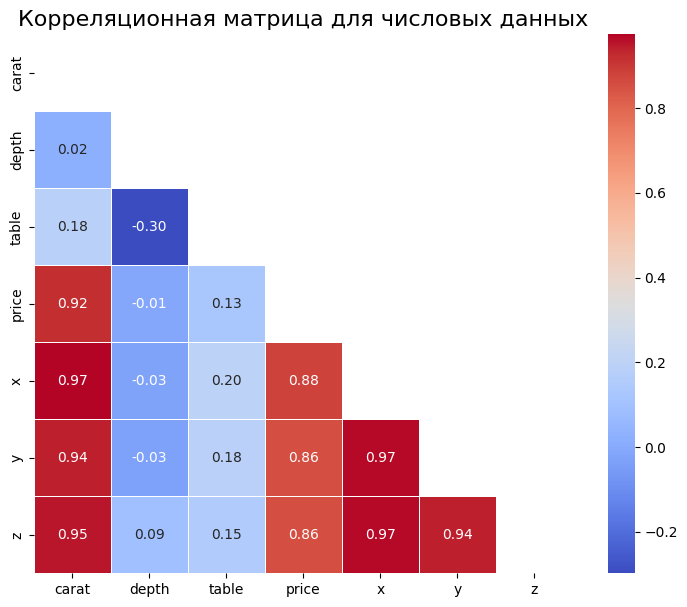

In [8]:
numeric_columns = data.select_dtypes(include=['float64', 'uint64', 'int64'])
correlation_matrix = numeric_columns.corr(method = 'pearson')
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, square=True)
plt.title('Корреляционная матрица для числовых данных', fontsize=16)
plt.show()

In [9]:
# plot_cols = data.columns
# n_cols = 3
# n_rows = (len(plot_cols) + n_cols - 1) // n_cols
# fig, ax = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(18, n_rows * 5))

# ax = ax.flatten()
# for index, col in enumerate(plot_cols):
#     sns.boxplot(y=col, data=data, ax=ax[index])

# for empty_ax in ax[len(plot_cols):]:
#     empty_ax.set_visible(False)

# plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
# plt.show()

In [10]:
# z = stats.zscore(data)
# display(z.head(10))
# data = data.drop(axis=1, columns=[''])[~(np.abs(z) > 3).any(axis=1)]
# data.head(3)

In [11]:
display(data.shape)

(40377, 10)

In [12]:
data = data.drop_duplicates(subset=['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z'])

In [13]:
data['volume'] = data['x']*data['y']*data['z']
data = data[['carat', 'x', 'y', 'z', 'depth', 'table', 'volume', 'clarity', 'cut', 'price', 'color']]

In [14]:
display(data.shape)
data.head(5)

(40251, 11)

,carat,x,y,z,depth,table,volume,clarity,cut,price,color
0,0.55,5.29,5.31,3.27,61.7,55.0,91.853973,SI1,Ideal,1134,I
1,0.94,6.27,6.24,3.90,62.4,56.0,152.586720,SI1,Premium,4580,E
2,0.33,4.49,4.47,2.69,60.0,59.0,53.989107,SI2,Premium,594,E
3,0.31,4.45,4.40,2.63,59.4,56.0,51.495400,VS2,Ideal,879,D
4,2.01,7.99,8.04,5.03,62.8,59.0,323.125188,SI1,Very Good,17759,H


In [15]:
train_data, test_data, train_target, test_target = train_test_split(data.drop(axis=1, columns=['price']), pd.DataFrame(data['price']), test_size=0.3, shuffle=True, random_state=13)#тут надо заполнить колонку с таргетом

In [16]:
display(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 28175 entries, 11534 to 33240
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    28175 non-null  float64
 1   x        28175 non-null  float64
 2   y        28175 non-null  float64
 3   z        28175 non-null  float64
 4   depth    28175 non-null  float64
 5   table    28175 non-null  float64
 6   volume   28175 non-null  float64
 7   clarity  28175 non-null  object 
 8   cut      28175 non-null  object 
 9   color    28175 non-null  object 
dtypes: float64(7), object(3)
memory usage: 2.4+ MB


None

In [17]:
category_features = ['cut']
numerical_features = ['carat', 'depth', 'table', 'volume', 'x', 'y', 'z']
spec_m = ['clarity', 'color']

In [18]:
nums = Pipeline(steps=[
    #('missing_nums', KNNImputer(missing_values=np.nan)), #проверить, дропнул ли na в eda, если да, то бесполезный код
    #('bins', KBinsDiscretizer(n_bins=10, strategy='uniform', encode='ordinal')), #делаем бинаризацию
    #('polynom', PolynomialFeatures(3, include_bias=False)), #делаем полиномы, если надо
    ('scaler', StandardScaler())]) #можно попробовать другие скейлеры

#если нужна замена признаков на численные, не просто onehot
clarity_map = [{
    'col':'clarity',
    'mapping':{'FL':10, 'IF':9, 'VVS1':8, 'VVS2':7, 'VS1':6, 'VS2':5, 
               'SI1':4, 'SI2':3, 'I1':2, 'I2':1, 'I3':0}
    },
    {'col': 'color',
    'mapping':{'D':6, 'E':5, 'F':4, 'G':3, 'H':2, 'I':1, 'J':0}}]

special_transformer = Pipeline(steps=[
    ('missing_nums', SimpleImputer(strategy = 'most_frequent')),
    ('ce',ce.OrdinalEncoder(mapping=clarity_map)),
    ('scaler', MinMaxScaler())
    ])    
    
CT = ColumnTransformer([
        ("with_nums", nums, numerical_features),
        ("with_category", OneHotEncoder(sparse_output=False, handle_unknown='error'), category_features), #если не одна категория, то лучше прописать параметр drop
        ("special_map", special_transformer, spec_m), #если нужна особая замена
        ]).set_output(transform='pandas')

display(CT)

ct = CT.fit_transform(train_data)
pd.DataFrame(ct).head(10).T


ColumnTransformer(transformers=[('with_nums',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['carat', 'depth', 'table', 'volume', 'x', 'y',
                                  'z']),
                                ('with_category',
                                 OneHotEncoder(sparse_output=False), ['cut']),
                                ('special_map',
                                 Pipeline(steps=[('missing_nums',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ce',
                                                  OrdinalEncoder(mapping=[{'col': 'clarity',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': FL      10
IF       9
VVS1     8
VVS2     7
VS1      6
VS2      5
SI1      4
SI2      3
I1       2
I2       1
I3       0
dtype: int64},
                                                                          {'col': 'color',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': D    6
E    5
F    4
G    3
H    2
I    1
J    0
dtype: int64}])),
                                                 ('scaler', MinMaxScaler())]),
                                 ['clarity', 'color'])])

,11534,25718,6697,39165,18606,31187,33716,10579,9864,23454
with_nums__carat,0.429767,-0.817803,-0.183445,0.387476,2.967195,-0.564060,-1.008110,-1.029255,3.178648,0.472057
with_nums__depth,0.669807,0.669807,0.880793,0.318164,0.669807,0.388493,-0.596106,-1.651034,0.036850,0.458821
with_nums__table,0.248978,-0.645171,-0.198096,-0.198096,0.248978,0.248978,1.143127,-0.198096,1.143127,-0.198096
with_nums__volume,0.415453,-0.791739,-0.164670,0.370990,2.870606,-0.517536,-0.978227,-0.960864,3.021581,0.446438
with_nums__x,0.545488,-0.899387,-0.043165,0.536569,2.320365,-0.489114,-1.193714,-1.140200,2.445231,0.607921
with_nums__y,0.588140,-0.834281,-0.011676,0.545296,2.173368,-0.405841,-1.134189,-1.057069,2.276194,0.596709
with_nums__z,0.667268,-0.816924,0.076473,0.595220,2.396423,-0.413454,-1.234803,-1.263622,2.410832,0.681677
with_category__cut_Fair,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
with_category__cut_Good,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
with_category__cut_Ideal,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000


In [19]:
model_pipeline = Pipeline(steps=[
    ('preprocessing', CT), #забиваем свой препроцессор, если надо, можно написать в feature engineering universal_preprocessor
    ('model', SVR())]) #забиваем свою модель, если надо
display(model_pipeline)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('with_nums',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'volume', 'x', 'y', 'z']),
                                                 ('with_category',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['cut']),
                                                 ('special_map',
                                                  Pipeline(steps=[('missing_nums',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ce',
                                                                   OrdinalEncoder(mapping=[{'col': 'clarity',
                                                                                            'data_type': dtype('O'),
                                                                                            'mapping': FL      10
IF       9
VVS1     8
VVS2     7
VS1      6
VS2      5
SI1      4
SI2      3
I1       2
I2       1
I3       0
dtype: int64},
                                                                                           {'col': 'color',
                                                                                            'data_type': dtype('O'),
                                                                                            'mapping': D    6
E    5
F    4
G    3
H    2
I    1
J    0
dtype: int64}])),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['clarity', 'color'])])),
                ('model', SVR())])

In [20]:
def irq_mse(y_true, y_predict):
    delta = y_predict - y_true
    q25 = np.quantile(delta, 0.25)
    q75 = np.quantile(delta, 0.75)
    iqr = q75-q25
    mask = ((delta<(q25-1.5*iqr)) | (delta>(q75+1.5*iqr)))
    if mask.sum() == 0:
        return 0
    else:
        return -sum((delta[mask])**2) / mask.sum()

In [21]:
iqr_mse_score = make_scorer(irq_mse)
iqr_mse_score

make_scorer(irq_mse, response_method='predict')

In [22]:
# Тут возьмем cv которая нравится
cv_1 = KFold(n_splits=3)

In [23]:
param_grid_for_model_pipeline = [
    {'model':[SVR()],#модели
     'model__alpha':[0.01, 0.1, 1, 10, 100],
     'preprocessing':[CT],
    'preprocessing__with_nums__scaler':[StandardScaler()]}
]

In [24]:
# Сама решетка, берем нужный пайп, нужные параметры, нужный скор, нужный cv
# grid = GridSearchCV(model_pipeline, n_jobs=-1, param_grid=param_grid_for_model_pipeline, scoring=iqr_mse_score, return_train_score=True, error_score="raise", cv=cv_1)
# grid.fit(train_data, train_target.values.ravel())

In [25]:
# gridresults = pd.DataFrame(grid.cv_results_)
# display(gridresults.T)

In [26]:
check_pipeline = Pipeline(steps=[
    ('preprocessing', CT), #забиваем свой препроцессор, если надо, можно написать в feature engineering universal_preprocessor
    ('model', SVR(C=100000))]) #забиваем свою модель, если надо
display(check_pipeline)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('with_nums',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'volume', 'x', 'y', 'z']),
                                                 ('with_category',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['cut']),
                                                 ('special_map',
                                                  Pipeline(steps=[('missing_nums',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ce',
                                                                   OrdinalEncoder(mapping=[{'col': 'clarity',
                                                                                            'data_type': dtype('O'),
                                                                                            'mapping': FL      10
IF       9
VVS1     8
VVS2     7
VS1      6
VS2      5
SI1      4
SI2      3
I1       2
I2       1
I3       0
dtype: int64},
                                                                                           {'col': 'color',
                                                                                            'data_type': dtype('O'),
                                                                                            'mapping': D    6
E    5
F    4
G    3
H    2
I    1
J    0
dtype: int64}])),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['clarity', 'color'])])),
                ('model', SVR(C=100000))])

In [27]:
# king = grid.best_estimator_
# display(king)
# king.fit(train_data, train_target.values.ravel())
# print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(iqr_mse_score(king, test_data, test_target.values.ravel())))#тут пишем свой скор

In [28]:
check_pipeline.fit(train_data, train_target.values.ravel())
print(irq_mse(test_target.values.ravel(), check_pipeline.predict(test_data)))

-2218669.7394011375


In [29]:
# print(irq_mse(test_target.values.ravel(), king.predict(test_data)))

In [30]:
# C=15000, [['carat', 'x', 'y', 'z', 'depth', 'table', 'volume', 'clarity', 'color', 'cut', 'price']]

In [31]:
model_pipe_tt = Pipeline([
                ('modeltt', TransformedTargetRegressor(
                        regressor = Pipeline(steps=[
                                ('preprocessing', CT),
                                ('model', SVR(C=15000))
                            ]),
                        transformer=QuantileTransformer(n_quantiles=1000, output_distribution="normal") #забиваем PowerTransformer(), если надо, не забывай про check_inverse = False
                ))])
display(model_pipe_tt)

Pipeline(steps=[('modeltt',
                 TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessing',
                                                                       ColumnTransformer(transformers=[('with_nums',
                                                                                                        Pipeline(steps=[('scaler',
                                                                                                                         StandardScaler())]),
                                                                                                        ['carat',
                                                                                                         'depth',
                                                                                                         'table',
                                                                                                         'volume',
                                                                                                         'x',
                                                                                                         'y',
                                                                                                         'z']),
                                                                                                       ('with_category',
                                                                                                        OneHotEncoder(sparse_output=False),
                                                                                                        ['cut']),
                                                                                                       ('special_map',
                                                                                                        Pipeline(steps=[('missing_nums',
                                                                                                                         Simple...
                                                                                                                        ('ce',
                                                                                                                         OrdinalEncoder(mapping=[{'col': 'clarity',
                                                                                                                                                  'data_type': dtype('O'),
                                                                                                                                                  'mapping': FL      10
IF       9
VVS1     8
VVS2     7
VS1      6
VS2      5
SI1      4
SI2      3
I1       2
I2       1
I3       0
dtype: int64},
                                                                                                                                                 {'col': 'color',
                                                                                                                                                  'data_type': dtype('O'),
                                                                                                                                                  'mapping': D    6
E    5
F    4
G    3
H    2
I    1
J    0
dtype: int64}])),
                                                                                                                        ('scaler',
                                                                                                                         MinMaxScaler())]),
                                                                                                        ['clarity',
                                                                                                         'color'])])),
                                                                      ('model',
                                             

In [32]:
# model_pipe_tt.fit(train_data.iloc[:20000], train_target.iloc[:20000].values.ravel())
# print(irq_mse(test_target.values.ravel(), model_pipe_tt.predict(test_data)))

In [33]:
last_version = check_pipeline.fit(data.drop(axis=1, columns=['price']), pd.DataFrame(data['price']))

C:\Users\Arseny\.conda\envs\ml_1\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [34]:
# # Запись модели
with open('svr-model.pkl', 'wb') as f:
     pickle.dump(last_version, f)